In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

### Задача 16

По описанию условий посева предсказать прорастут семена растений или нет. Провести бинарную классификацию семян с помощью метода Парзеновского окна. Построить график зависимости ошибки на контроле от ширины окна. Подобрать оптимальную ширину окна.

In [2]:
columns = ['season',  'age', 'childish diseases', 'accident',  'surgical intervention', 'high fevers', 
'frequency of alcohol consumption', 'smoking habit', 'number of hours spent sitting per day', 'output']

In [3]:
df = pd.read_csv('fertility_Diagnosis.txt', names = columns)
df['output'] = df['output'] == 'N'
df.head()

,season,age,childish diseases,accident,surgical intervention,high fevers,frequency of alcohol consumption,smoking habit,number of hours spent sitting per day,output
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,True
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,False
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,True
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,True
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,False


In [4]:
len(df)

100

In [5]:
np.sum(df['output'])

88

С самого начала мочется объединить признаки 'Season' и 'age', создав один временной ряд, но это будет не совсем корректно: в первом случае имеем периодическое явление, а во втором графа "год" соответствует скорее категориальному признаку: был ли тот или иной год благоприятным для растений, скорее, независимая случайная величина. Но откажемся и от перехода к категриальным признакам: это слишком сильно повысит размерность нашего простанства.

In [6]:
X = df.drop('output', axis = 1)
y = df['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [49]:
epan = lambda r : 3 / 4 * (1 - r ** 2) * (np.abs(r) <= 1)
square = lambda r : 15 / 16 * (1 - r ** 2) ** 2 * [np.abs(r) <= 1]
triangle = lambda r :  (1 - np.abs(r)) * [np.abs(r) <= 1]
gaussean = lambda r : (2 * np.pi) ** (-1 / 2) * np.exp(-1 / 2 * r ** 2)
rectangular = lambda r : 0.5 * (np.abs(r) <= 1)
kernels = [epan, square, triangle, gaussean, rectangular]
kernel_names = ['epan', 'square', 'triangle', 'gaussean', 'rectangular']

In [37]:
h =  5
dist_l2 = lambda x, x1 : (np.linalg.norm(x - x1)) ** 2

def get_dencity(members, x, h=2, K=epan):
    dists = np.array([dist_l2(u, x) for u in members.values])
    return np.sum(K(dists / h))

def predict_single(x, h=2, K=epan):
    subclasses = [X_train[y_train], X_train[~y_train]]
    dencity = np.array([get_dencity(members, x, h, K) for members in subclasses])
    dencity /= np.sum(dencity) # На самом деле, эта строчка не имеет никакого алгоритмического смысла       
    return dencity[0] >= dencity[1]

def predict(values, h=2, K=epan):
    return np.array([predict_single(x, h, K) for x in values])

In [38]:
predicted = predict(X_test.values, 3)
accuracy = np.sum(predicted == y_test) / len(y_test)
accuracy  

0.8857142857142857

In [51]:
print(prediction)
print(list(y_test))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
[True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False]


Что же, видим очевидную проблему: за счет того, что значений false в выборке весьма мало,
у нас ответы практически всегда - только true. Посмотрим, что можно с этим зделать.

/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


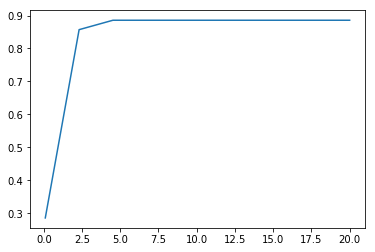

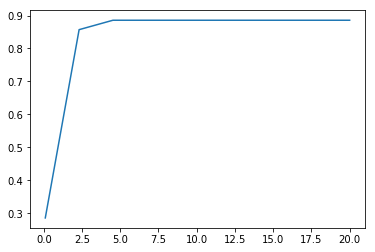

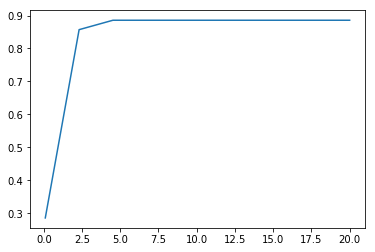

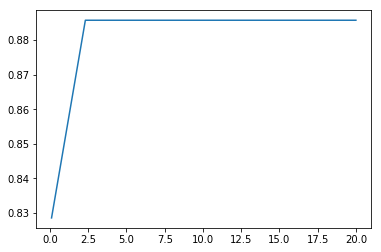

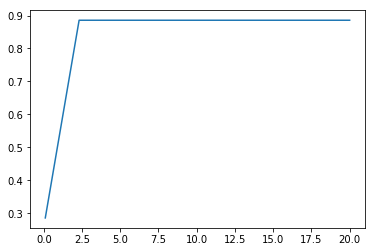

In [56]:
h_es = np.linspace(0.1, 20, 10)

for kernel, name in zip(kernels, kernel_names):
    accuracies = []
    for h in h_es:
        prediction = predict(X_test.values, h, K=kernel)
        accuracy = np.sum(prediction == y_test) / len(y_test)
        accuracies.append(accuracy)
    plt.plot(h_es, accuracies)
    plt.show()

Видим, что длина окна практически никак нас не спасает: нужно, во-первых, прожумывать метрику растояний между различными элементами выборки, во-вторых, увеличивать саму выборку, потому что умерших растений просто недостаточно. Ну, или искать багу)